# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [18]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [19]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

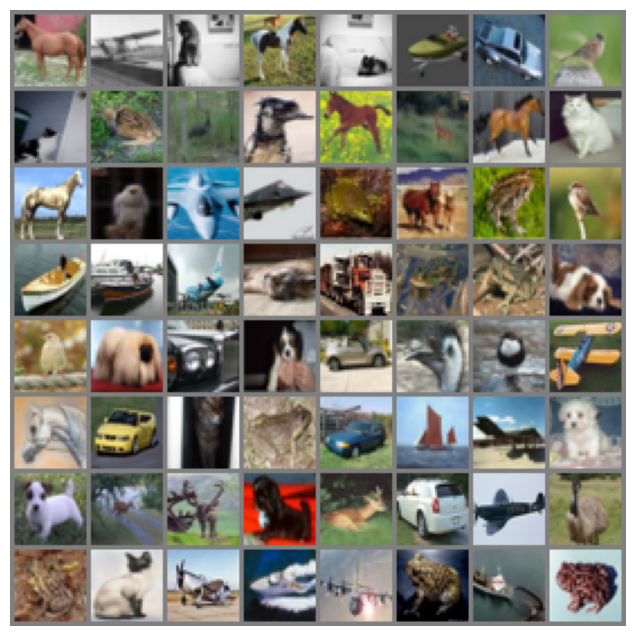

In [20]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [21]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Your code here!

    def forward(self, x):
        # Your code here!
        return x


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model()


<h2 style="color: white;">Solution 1</h2>


In [22]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x
    
class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # get the number of classes
        self.num_classes = num_classes
        # define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5,stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5,stride=1, padding=1)
        self.fc1 = nn.Linear(6*6*256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
        # define dropout layer
        self.dropout = nn.Dropout(0.25)
        # define batch normalization
        self.batchnorm1 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
        x = self.dropout(x)
        x = self.batchnorm1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

engine = 'cpu'
model = Model(n_classes)
device = torch.device(engine)
model.to(device)
print(model)

    

Model(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [23]:
loss_fn = None  # Your code here!
optimizer = None  # Your code here!


<h2 style="color: white;">Solution 2</h2>


In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [25]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.00867363  0.03393313 -0.10798015  0.00683605 -0.1236382   0.04645401
  -0.11507212  0.08248409 -0.09863435  0.01105105]
 [ 0.02240871  0.02758528 -0.07713252  0.03628872 -0.11946999 -0.00432092
  -0.1360898   0.02274313 -0.13531372  0.10937567]]
Output probabilities:
[[0.10161474 0.10603777 0.0920086  0.10320304 0.09057915 0.1073738
  0.09135839 0.11131303 0.09287252 0.10363896]
 [0.10455355 0.10509618 0.09464738 0.10601488 0.09072389 0.10179589
  0.08922853 0.10458852 0.08929781 0.11405335]]


In [ ]:
batch_size = 64
num_epochs = 2
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

<h2 style="color: white;">Solution 3</h2>


In [27]:
batch_size = 64
num_epochs = 20
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    if (epoch+1)%2 == 0:
        print(f"Epoch being trained: {epoch+1}")
        
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Foward pass
        output = model(inputs)
        # Compute gradients
        loss = loss_fn(output, targets)
        # Zero the gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Perform one training step
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.353625
             test accuracy: 0.475
Epoch being trained: 2
Step 1000    training accuracy: 0.5237241972477065
             test accuracy: 0.5465
Step 1500    training accuracy: 0.56190625
             test accuracy: 0.5979
Step 2000    training accuracy: 0.6170441513761468
             test accuracy: 0.64
Epoch being trained: 4
Step 2500    training accuracy: 0.6650771103896104
             test accuracy: 0.6626
Step 3000    training accuracy: 0.66534375
             test accuracy: 0.6734
Step 3500    training accuracy: 0.6944724462365591
             test accuracy: 0.6888
Epoch being trained: 6
Step 4000    training accuracy: 0.7324652777777778
             test accuracy: 0.6963
Step 4500    training accuracy: 0.720375
             test accuracy: 0.7148
Step 5000    training accuracy: 0.7478185876623377
             test accuracy: 0.7159
Epoch being trained: 8
Step 5500    training accuracy: 0.765625
             test accuracy: 0.7274
Step 6000  

<h2 style="color: white;">First Attempt of Solution 4 : Code</h2>
This is part of the answer for Assignment 4. 

I made a modification by adjusting the number of epochs to 50. 

You can find more attempts listed below.

In [28]:
batch_size = 64
num_epochs = 50
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    if (epoch+1)%2 == 0:
        print(f"Epoch being trained: {epoch+1}")
        
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Foward pass
        output = model(inputs)
        # Compute gradients
        loss = loss_fn(output, targets)
        # Zero the gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Perform one training step
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.95703125
             test accuracy: 0.7696
Epoch being trained: 2
Step 1000    training accuracy: 0.9648795871559633
             test accuracy: 0.7748
Step 1500    training accuracy: 0.959375
             test accuracy: 0.7665
Step 2000    training accuracy: 0.9729071100917431
             test accuracy: 0.7747
Epoch being trained: 4
Step 2500    training accuracy: 0.971387987012987
             test accuracy: 0.776
Step 3000    training accuracy: 0.97496875
             test accuracy: 0.7765
Step 3500    training accuracy: 0.980426747311828
             test accuracy: 0.7717
Epoch being trained: 6
Step 4000    training accuracy: 0.9817708333333334
             test accuracy: 0.7762
Step 4500    training accuracy: 0.98234375
             test accuracy: 0.7731
Step 5000    training accuracy: 0.982903814935065
             test accuracy: 0.7714
Epoch being trained: 8
Step 5500    training accuracy: 0.9831730769230769
             test accuracy: 0.7658


## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

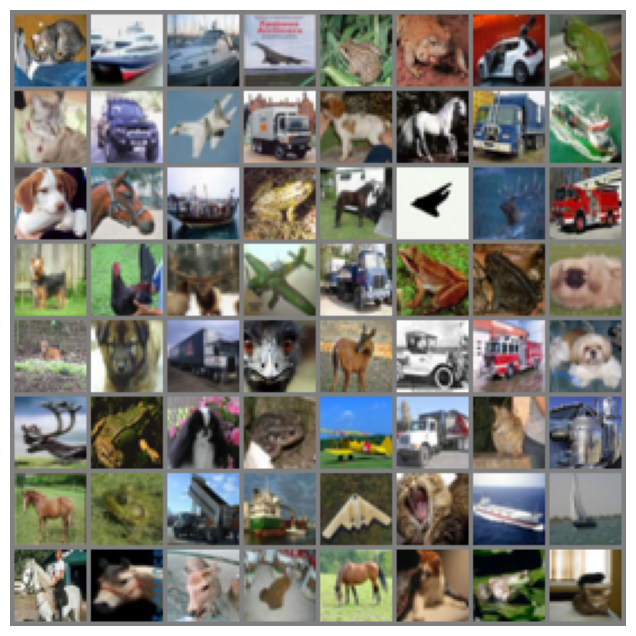

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane        bird     
    deer          deer     
    truck         truck    
     dog          deer     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           d

In [29]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [30]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [31]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.778


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


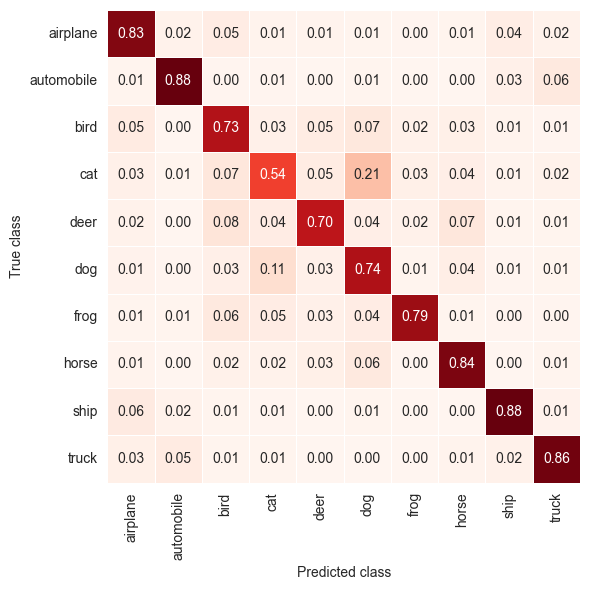

In [32]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

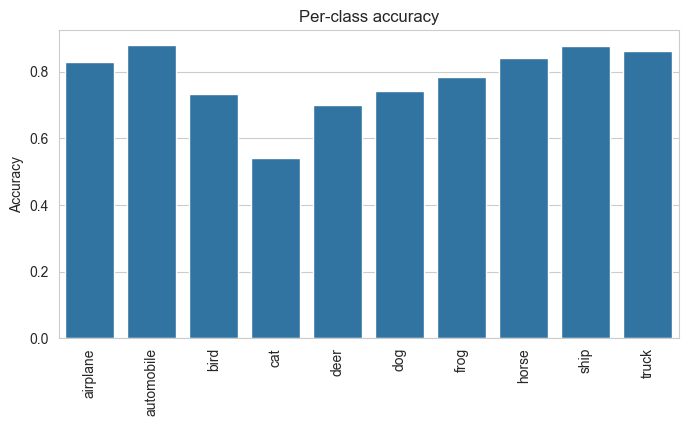

In [33]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.


<h2 style="color: white;">Solution 4</h2>

In [44]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from math import floor
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter

# Defining the hyperparameter combinations
test_mode = 0
if test_mode == 1:
    conv_layers = [1]
    out_channels = [16]
    kernel_size = [5]
    padding = [0]
    stride = [1]
    pooling = [0]
    dropout = [0]
    batchnorm = [0]
else:
    conv_layers = [1, 2]
    out_channels = [10, 16, 20]
    kernel_size = [3, 5, 7]
    padding = [0, 1]
    stride = [1]
    pooling = [0, 1]
    dropout = [0, 1]
    batchnorm = [0, 1]

setup_settings = [x for x in itertools.product(conv_layers, out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm)]
total_number_of_setups = len(setup_settings)

# Splitting the setups into parts for more manageable experiments
splits = 7
part = total_number_of_setups // splits
parts = [i * part for i in range(splits)]
parts.append(total_number_of_setups)

###############
split = 7  # Choose a split between 1 and 7 (inclusive)
###############

if test_mode == 1:
    active_setups = setup_settings[:2]
else:
    if split == 1:
        active_setups = setup_settings[:parts[0]]
    else:
        active_setups = setup_settings[parts[split-2]:parts[split-1]]

number_of_setups = len(active_setups)

# Defining the CNN Model
class Model(nn.Module):
    def __init__(self, conv_layers, out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm, num_classes=10):
        super().__init__()
        self.conv_layers = conv_layers
        self.pooling = pooling
        self.dropout = dropout
        self.batchnorm = batchnorm
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        if conv_layers == 2:
            self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        
        # Calculate output dimensions for the fully connected layer
        conv_out_dim = (32 - kernel_size + 2 * padding) / stride + 1
        if pooling == 1:
            conv_out_dim = conv_out_dim // 2
        if conv_layers == 2:
            conv_out_dim = (conv_out_dim - kernel_size + 2 * padding) / stride + 1
            if pooling == 1:
                conv_out_dim = conv_out_dim // 2
        
        conv_to_linear = int((conv_out_dim ** 2) * out_channels)

        # Fully connected layers
        self.fc1 = nn.Linear(conv_to_linear, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # Optional layers
        self.dropout_layer = nn.Dropout(0.5) if dropout else None
        self.batchnorm_layer = nn.BatchNorm1d(self.fc1.out_features) if batchnorm else None

    def forward(self, x):
        x = F.relu(self.conv1(x))
        if self.pooling:
            x = F.max_pool2d(x, (2, 2))
        if self.conv_layers == 2:
            x = F.relu(self.conv2(x))
            if self.pooling:
                x = F.max_pool2d(x, (2, 2))
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        if self.dropout_layer:
            x = self.dropout_layer(x)
        if self.batchnorm_layer:
            x = self.batchnorm_layer(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Optimized training loop with mixed precision and validation tracking
def train_model(model, train_loader, test_loader, device, epochs, lr=0.01):
    scaler = GradScaler()  # For mixed precision
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-6)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    model.train()
    writer = SummaryWriter()  # TensorBoard logging
    step = 0
    best_valid_accuracy = 0
    best_setup = None

    for epoch in range(epochs):
        train_accuracies_batches = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            with autocast():  # Mixed precision forward pass
                output = model(inputs)
                loss = loss_fn(output, targets)

            scaler.scale(loss).backward()  # Scales gradients
            scaler.step(optimizer)
            scaler.update()

            predictions = output.argmax(dim=1)
            accuracy = (predictions == targets).float().mean().item()
            train_accuracies_batches.append(accuracy)

            step += 1
            if step % 100 == 0:
                writer.add_scalar('Training Loss', loss.item(), step)
                writer.add_scalar('Training Accuracy', np.mean(train_accuracies_batches), step)

        # Validation step after each epoch
        valid_accuracies = []
        model.eval()
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs)
                predictions = output.argmax(dim=1)
                accuracy = (predictions == targets).float().mean().item()
                valid_accuracies.append(accuracy)

        avg_valid_acc = np.mean(valid_accuracies)
        writer.add_scalar('Validation Accuracy', avg_valid_acc, epoch)
        scheduler.step()  # Adjust learning rate

        # Track the best model based on validation accuracy
        if avg_valid_acc > best_valid_accuracy:
            best_valid_accuracy = avg_valid_acc
            best_setup = model.state_dict()  # Save the best model's state_dict
        
        print(f'Epoch {epoch + 1}, Validation Accuracy: {avg_valid_acc}')
        model.train()

    return best_valid_accuracy, best_setup

# Loop over the setups and track the best setup
best_accuracy = 0
best_model_state_dict = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i, setup in enumerate(active_setups):
    conv_layers, out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm = setup
    model = Model(conv_layers, out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm).to(device)
    
    print(f"Training setup {i+1}/{number_of_setups}")
    valid_accuracy, best_setup = train_model(model, train_loader, test_loader, device, epochs=15)
    
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_model_state_dict = best_setup

# Load the best model for predictions
best_model = Model(conv_layers, out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm).to(device)
best_model.load_state_dict(best_model_state_dict)
best_model.eval()



Training setup 1/41


C:\Users\chens\AppData\Local\Temp\ipykernel_20728\2624596374.py:111: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision
C:\Users\chens\AppData\Local\Temp\ipykernel_20728\2624596374.py:128: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Epoch 1, Validation Accuracy: 0.5987580128205128
Epoch 2, Validation Accuracy: 0.6421274038461539
Epoch 3, Validation Accuracy: 0.6540464743589743
Epoch 4, Validation Accuracy: 0.6792868589743589
Epoch 5, Validation Accuracy: 0.6916065705128205
Epoch 6, Validation Accuracy: 0.6968149038461539
Epoch 7, Validation Accuracy: 0.698417467948718
Epoch 8, Validation Accuracy: 0.6962139423076923
Epoch 9, Validation Accuracy: 0.7050280448717948
Epoch 10, Validation Accuracy: 0.7049278846153846
Epoch 11, Validation Accuracy: 0.7309695512820513
Epoch 12, Validation Accuracy: 0.7307692307692307
Epoch 13, Validation Accuracy: 0.7298677884615384
Epoch 14, Validation Accuracy: 0.729667467948718
Epoch 15, Validation Accuracy: 0.7285657051282052
Training setup 2/41
Epoch 1, Validation Accuracy: 0.4716546474358974
Epoch 2, Validation Accuracy: 0.5385616987179487
Epoch 3, Validation Accuracy: 0.5950520833333334
Epoch 4, Validation Accuracy: 0.6119791666666666
Epoch 5, Validation Accuracy: 0.63671875
Epoc

Model(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=720, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (batchnorm_layer): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

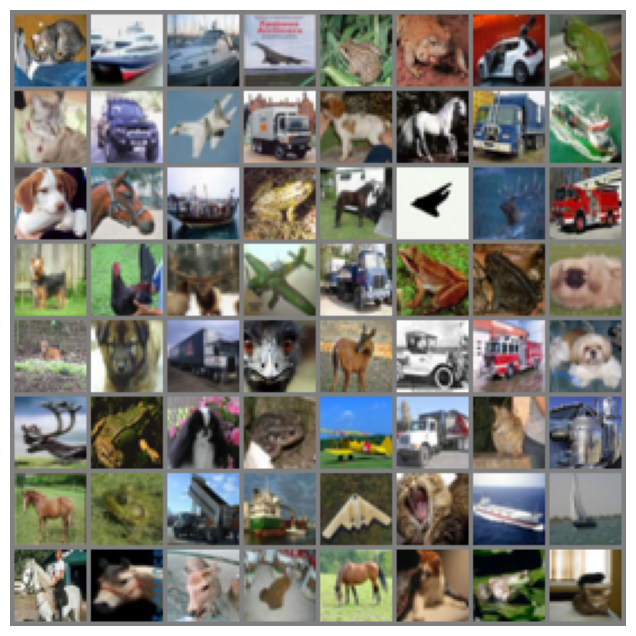

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship       automobile  
  airplane      airplane   
    frog          deer     
    frog          frog     
 automobile    automobile  
    frog          bird     
     cat           cat     
 automobile       truck    
  airplane      airplane   
    truck         truck    
     dog          deer     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane        bird     
    deer          deer     
    truck         truck    
     dog          deer     
    bird          deer     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           c

In [45]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


In [46]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


In [47]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.730


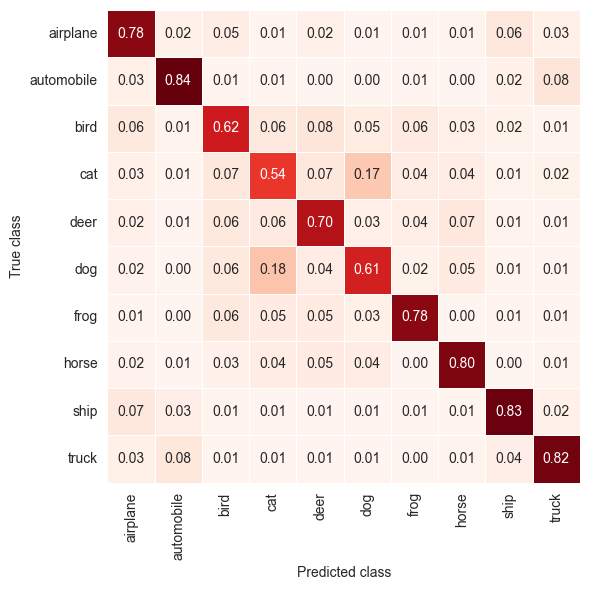

In [48]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

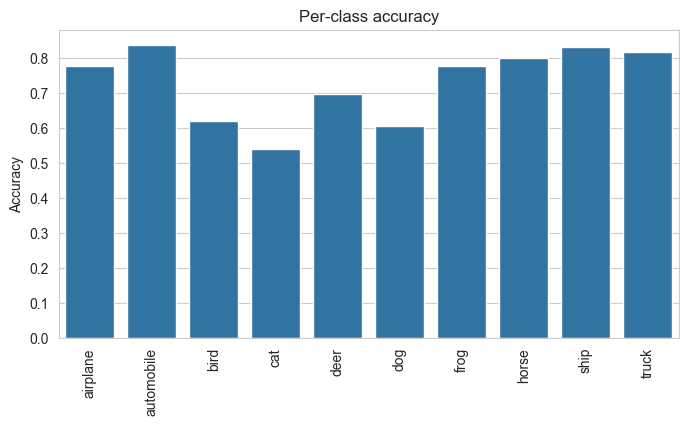

In [49]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [50]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['NVIDIA GeForce RTX 3060 Laptop GPU']


<h2 style="color: white;">Solution for optional assignment</h2>

Please refer to the solution for Assignment 4. My laptop is equipped with an RTX 3060 CUDA device, which I’ve successfully integrated. 

Indeed, the performance is significantly faster compared to using a CPU.

You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**



